#  Multimodal Depression Detection (DAIC-WOZ) — Research Pipeline




In [9]:
import os, json, glob
import pandas as pd
import numpy as np
from IPython.display import display


In [10]:
DATA_DIR = "E:/Mental_Health_Detection/DepressionDetection/data/"

TRAIN_SPLIT = os.path.join(DATA_DIR, "train_split_Depression_AVEC2017.csv")
DEV_SPLIT   = os.path.join(DATA_DIR, "dev_split_Depression_AVEC2017.csv")
TEST_SPLIT  = os.path.join(DATA_DIR, "test_split_Depression_AVEC2017.csv")

FEATURE_TEMPLATES = [
    "{pid}_COVAREP.csv",
    "{pid}_FORMANT.csv",
    "{pid}_CLNF_features3D.txt",
    "{pid}_CLNF_AUs.txt",
    "{pid}_CLNF_gaze.txt",
    "{pid}_CLNF_pose.txt",
]


In [11]:
df_train_raw = pd.read_csv(TRAIN_SPLIT)
df_dev_raw = pd.read_csv(DEV_SPLIT)
df_test_raw = pd.read_csv(TEST_SPLIT)

print("Train columns:", df_train_raw.columns.tolist())
print("Dev columns:", df_dev_raw.columns.tolist())
print("Test columns:", df_test_raw.columns.tolist())

display(df_train_raw.head())


Train columns: ['Participant_ID', 'PHQ8_Binary', 'PHQ8_Score', 'Gender', 'PHQ8_NoInterest', 'PHQ8_Depressed', 'PHQ8_Sleep', 'PHQ8_Tired', 'PHQ8_Appetite', 'PHQ8_Failure', 'PHQ8_Concentrating', 'PHQ8_Moving']
Dev columns: ['Participant_ID', 'PHQ8_Binary', 'PHQ8_Score', 'Gender', 'PHQ8_NoInterest', 'PHQ8_Depressed', 'PHQ8_Sleep', 'PHQ8_Tired', 'PHQ8_Appetite', 'PHQ8_Failure', 'PHQ8_Concentrating', 'PHQ8_Moving']
Test columns: ['participant_ID', 'Gender']


,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving
0,303,0,0,0,0,0,0.0,0,0,0,0,0
1,304,0,6,0,0,1,1.0,2,2,0,0,0
2,305,0,7,1,0,1,1.0,2,2,1,0,0
3,310,0,4,1,1,1,0.0,0,0,1,1,0
4,312,0,2,1,0,0,1.0,1,0,0,0,0


In [12]:
full_test_path = os.path.join(DATA_DIR, "full_test_split.csv")

if os.path.exists(full_test_path):
    full_test_df_raw = pd.read_csv(full_test_path)
    print("full_test_split.csv columns:", full_test_df_raw.columns.tolist())
    display(full_test_df_raw.head())
else:
    print("full_test_split.csv not found in DATA_DIR")


full_test_split.csv columns: ['Participant_ID', 'PHQ_Binary', 'PHQ_Score', 'Gender']


,Participant_ID,PHQ_Binary,PHQ_Score,Gender
0,300,0,2,1
1,301,0,3,1
2,306,0,0,0
3,308,1,22,0
4,309,1,15,1


In [13]:
def load_split(csv_path, split_type="train"):
    df = pd.read_csv(csv_path)

    for pid_col in ["Participant_ID", "participant_ID", "participant", "subject"]:
        if pid_col in df.columns:
            df = df.rename(columns={pid_col: "pid"})
            break

    if split_type in ["train", "dev"]:
        for label_col in ["PHQ8_Binary", "PHQ_Binary", "label", "PHQ8_binary"]:
            if label_col in df.columns:
                df = df.rename(columns={label_col: "y"})
                break
        return df[["pid", "y"]]

    return df[["pid"]]


train_df = load_split(TRAIN_SPLIT, "train")
dev_df   = load_split(DEV_SPLIT, "dev")
test_df  = load_split(TEST_SPLIT, "test")

full_test_path = os.path.join(DATA_DIR, "full_test_split.csv")
full_test_df = None
if os.path.exists(full_test_path):
    full_test_df = load_split(full_test_path, "dev")  # treat like dev (has labels)
    print(" Loaded full_test_split.csv (labeled test set)")


 Loaded full_test_split.csv (labeled test set)


In [14]:
print("Counts:")
display({
    "train": train_df.shape,
    "dev": dev_df.shape,
    "test (unlabeled)": test_df.shape,
    "full_test (labeled)": full_test_df.shape if full_test_df is not None else None
})

print("\nTrain class balance:")
display(train_df.y.value_counts())

print("\nDev class balance:")
display(dev_df.y.value_counts())

if full_test_df is not None:
    print("\nFull test class balance:")
    display(full_test_df.y.value_counts())


Counts:


{'train': (107, 2),
 'dev': (35, 2),
 'test (unlabeled)': (47, 1),
 'full_test (labeled)': (47, 2)}


Train class balance:


y
0    77
1    30
Name: count, dtype: int64


Dev class balance:


y
0    23
1    12
Name: count, dtype: int64


Full test class balance:


y
0    33
1    14
Name: count, dtype: int64

Preprocessing & Feature Tensor Builder

In [15]:
!pip install torch==2.1.2 torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://download.pytorch.org/whl/cpu



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
!pip install "numpy<2.0" --upgrade



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
import torch, numpy as np
print("Torch:", torch.__version__)
print("Numpy:", np.__version__)
print("CUDA available:", torch.cuda.is_available())


Torch: 2.1.2+cpu
Numpy: 1.26.4
CUDA available: False


In [18]:
import os
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

DATA_DIR = "E:/Mental_Health_Detection/DepressionDetection/data"  
MAX_FRAMES = 8000    
AUDIO_DIM = 74
VIDEO_DIM = 204        


In [19]:
def load_video(pid):
    folder = f"{pid}_P"
    path = os.path.join(DATA_DIR, folder, f"{pid}_CLNF_features3D.txt")

    clean_rows = []

    with open(path, "r") as f:
        for line in f:
            parts = line.replace(",", " ").split()
            row = []
            for val in parts:
                try:
                    row.append(float(val))
                except:
                    row.append(np.nan)
            clean_rows.append(row)

    df = pd.DataFrame(clean_rows)

    df = df.apply(pd.to_numeric, errors="coerce")
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(0)
    df = np.clip(df, -1000, 1000)

    return df.values[:, :VIDEO_DIM]


In [20]:
def load_audio(pid):
    folder = f"{pid}_P"
    path = os.path.join(DATA_DIR, folder, f"{pid}_COVAREP.csv")

    df = pd.read_csv(path, engine="python")
    df = df.apply(pd.to_numeric, errors="coerce")

    df = df.replace([np.inf, -np.inf], np.nan)

    df = df.fillna(0)

    df = np.clip(df, -1000, 1000)

    return df.values[:, :AUDIO_DIM]


In [21]:
def pad_and_mask(arr, max_len):
    length = min(len(arr), max_len)
    padded = np.zeros((max_len, arr.shape[1]))
    mask = np.zeros(max_len)
    padded[:length] = arr[:length]
    mask[:length] = 1
    return padded, mask


In [22]:
pid = train_df.pid.iloc[0]
audio_file = os.path.join(DATA_DIR, f"{pid}_P", f"{pid}_COVAREP.csv")
video_file = os.path.join(DATA_DIR, f"{pid}_P", f"{pid}_CLNF_features3D.txt")

print("PID:", pid)
print("Audio exists:", os.path.exists(audio_file), audio_file)
print("Video exists:", os.path.exists(video_file), video_file)


PID: 303
Audio exists: True E:/Mental_Health_Detection/DepressionDetection/data\303_P\303_COVAREP.csv
Video exists: True E:/Mental_Health_Detection/DepressionDetection/data\303_P\303_CLNF_features3D.txt


In [23]:
audio_scaler = StandardScaler()
video_scaler = StandardScaler()

for pid in tqdm(train_df.pid, desc="Fitting scalers"):
    a = load_audio(pid)
    audio_scaler.partial_fit(a)

    v = load_video(pid)
    video_scaler.partial_fit(v)


Fitting scalers: 100%|██████████| 107/107 [14:41<00:00,  8.24s/it]


In [24]:
def build_tensors(df, name):
    audios, videos = [], []
    masks_audio, masks_video = [], []
    labels = []

    for pid in tqdm(df.pid, desc=f"Processing {name}"):
        a = audio_scaler.transform(load_audio(pid))
        v = video_scaler.transform(load_video(pid))

        pa, ma = pad_and_mask(a, MAX_FRAMES)
        pv, mv = pad_and_mask(v, MAX_FRAMES)

        audios.append(pa)
        videos.append(pv)
        masks_audio.append(ma)
        masks_video.append(mv)

        # label or placeholder
        if "y" in df.columns:
            labels.append(int(df[df.pid == pid].y.values[0]))
        else:
            labels.append(-1)

    torch.save(torch.tensor(audios, dtype=torch.float32), f"{name}_audio.pt")
    torch.save(torch.tensor(videos, dtype=torch.float32), f"{name}_video.pt")
    torch.save(torch.tensor(masks_audio, dtype=torch.float32), f"{name}_mask_audio.pt")
    torch.save(torch.tensor(masks_video, dtype=torch.float32), f"{name}_mask_video.pt")
    torch.save(torch.tensor(labels, dtype=torch.long), f"{name}_labels.pt")


In [25]:
build_tensors(train_df, "train")
build_tensors(dev_df, "dev")
build_tensors(test_df, "test")
if full_test_df is not None:
    build_tensors(full_test_df, "full_test")


Processing train: 100%|██████████| 107/107 [14:46<00:00,  8.29s/it]
C:\Users\savat\AppData\Local\Temp\ipykernel_15348\550908636.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  torch.save(torch.tensor(audios, dtype=torch.float32), f"{name}_audio.pt")
Processing full_test: 100%|██████████| 47/47 [07:19<00:00,  9.34s/it]


In [26]:
x = torch.load("train_audio.pt")
m = torch.load("train_mask_audio.pt")

print("Audio tensor:", x.shape)
print("Mask tensor:", m.shape)
print("Avg frames per sample:", m.sum(dim=1).mean().item())


Audio tensor: torch.Size([107, 8000, 74])
Mask tensor: torch.Size([107, 8000])
Avg frames per sample: 8000.0


In [27]:
import torch
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self, split):
        self.x = torch.load(f"{split}_audio.pt")
        self.m = torch.load(f"{split}_mask_audio.pt")
        self.y = torch.load(f"{split}_labels.pt")
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.m[idx], self.y[idx]

train_ds = AudioDataset("train")
dev_ds   = AudioDataset("dev")

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
dev_loader   = DataLoader(dev_ds, batch_size=8, shuffle=False)


In [28]:
def masked_mean(x, mask):
    mask = mask.unsqueeze(-1)  
    x = x * mask                
    return x.sum(dim=1) / mask.sum(dim=1).clamp(min=1e-9)


In [29]:
import torch.nn as nn
import torch.optim as optim

class AudioModel(nn.Module):
    def __init__(self, input_dim=74, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(hidden_dim*2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, mask):
        out, _ = self.lstm(x)
        pooled = masked_mean(out, mask)
        pooled = self.dropout(pooled)
        logits = self.fc(pooled)
        return self.sigmoid(logits)


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AudioModel().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def evaluate():
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x, m, y in dev_loader:
            x, m, y = x.to(device), m.to(device), y.to(device).float()
            pred = model(x, m).squeeze()
            pred_label = (pred > 0.5).long()
            correct += (pred_label == y).sum().item()
            total += len(y)
    return correct / total

best_acc = 0

for epoch in range(15):
    model.train()
    for x, m, y in train_loader:
        x, m, y = x.to(device), m.to(device), y.to(device).float()
        pred = model(x, m).squeeze()
        loss = criterion(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    acc = evaluate()
    print(f"Epoch {epoch+1}/15 | Loss: {loss.item():.4f} | Val Acc: {acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "audio_baseline.pt")
        print(" Saved best model")


Epoch 1/15 | Loss: 0.6660 | Val Acc: 0.6571
 Saved best model
Epoch 2/15 | Loss: 0.6508 | Val Acc: 0.6571
Epoch 3/15 | Loss: 0.7968 | Val Acc: 0.6571
Epoch 4/15 | Loss: 0.6077 | Val Acc: 0.6571
Epoch 5/15 | Loss: 0.6399 | Val Acc: 0.6571
Epoch 6/15 | Loss: 0.7304 | Val Acc: 0.6571
Epoch 7/15 | Loss: 0.5478 | Val Acc: 0.6571
Epoch 8/15 | Loss: 0.5130 | Val Acc: 0.6571
Epoch 9/15 | Loss: 0.6437 | Val Acc: 0.6571
Epoch 10/15 | Loss: 0.6386 | Val Acc: 0.6571
Epoch 11/15 | Loss: 0.5942 | Val Acc: 0.6571
Epoch 12/15 | Loss: 0.7044 | Val Acc: 0.6571
Epoch 13/15 | Loss: 0.7672 | Val Acc: 0.6571
Epoch 14/15 | Loss: 0.6924 | Val Acc: 0.6571
Epoch 15/15 | Loss: 0.6845 | Val Acc: 0.6571


Video Baseline Model

In [31]:
class VideoDataset(Dataset):
    def __init__(self, split):
        self.x = torch.load(f"{split}_video.pt")
        self.m = torch.load(f"{split}_mask_video.pt")
        self.y = torch.load(f"{split}_labels.pt")
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.m[idx], self.y[idx]

train_v = VideoDataset("train")
dev_v   = VideoDataset("dev")

train_loader_v = DataLoader(train_v, batch_size=8, shuffle=True)
dev_loader_v   = DataLoader(dev_v, batch_size=8, shuffle=False)


Video Model (BiLSTM)

In [32]:
class VideoModel(nn.Module):
    def __init__(self, input_dim=VIDEO_DIM, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(hidden_dim*2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, mask):
        out, _ = self.lstm(x)
        pooled = masked_mean(out, mask)
        pooled = self.dropout(pooled)
        return self.sigmoid(self.fc(pooled))


Train Video Baseline

In [33]:
video_model = VideoModel().to(device)
optimizer = optim.Adam(video_model.parameters(), lr=1e-4)

best_acc = 0

def evaluate_video():
    video_model.eval()
    correct = total = 0
    with torch.no_grad():
        for x, m, y in dev_loader_v:
            x, m, y = x.to(device), m.to(device), y.to(device).float()
            pred = video_model(x, m).squeeze()
            pred_label = (pred > 0.5).long()
            correct += (pred_label == y).sum().item()
            total += len(y)
    return correct / total

for epoch in range(15):
    video_model.train()
    for x, m, y in train_loader_v:
        x, m, y = x.to(device), m.to(device), y.to(device).float()
        pred = video_model(x, m).squeeze()
        loss = criterion(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    acc = evaluate_video()
    print(f"Epoch {epoch+1}/15 | Loss: {loss.item():.4f} | Val Acc: {acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        torch.save(video_model.state_dict(), "video_baseline.pt")
        print(" Saved best video model")


Epoch 1/15 | Loss: 0.5383 | Val Acc: 0.6571
 Saved best video model
Epoch 2/15 | Loss: 0.5804 | Val Acc: 0.6571
Epoch 3/15 | Loss: 0.4884 | Val Acc: 0.6571
Epoch 4/15 | Loss: 0.3825 | Val Acc: 0.6571
Epoch 5/15 | Loss: 0.5825 | Val Acc: 0.6571
Epoch 6/15 | Loss: 0.4880 | Val Acc: 0.6571
Epoch 7/15 | Loss: 0.8220 | Val Acc: 0.6571
Epoch 8/15 | Loss: 0.4993 | Val Acc: 0.6571
Epoch 9/15 | Loss: 0.5208 | Val Acc: 0.6571
Epoch 10/15 | Loss: 0.4643 | Val Acc: 0.6571
Epoch 11/15 | Loss: 0.5021 | Val Acc: 0.6571
Epoch 12/15 | Loss: 0.6996 | Val Acc: 0.6571
Epoch 13/15 | Loss: 0.4396 | Val Acc: 0.6571
Epoch 14/15 | Loss: 0.4306 | Val Acc: 0.6571
Epoch 15/15 | Loss: 0.3879 | Val Acc: 0.6571


Modality-Aware Gated Fusion (MAGF)

In [34]:
audio_model = AudioModel().to(device)
video_model = VideoModel().to(device)

audio_model.load_state_dict(torch.load("audio_baseline.pt", map_location=device))
video_model.load_state_dict(torch.load("video_baseline.pt", map_location=device))

audio_model.eval()
video_model.eval()


VideoModel(
  (lstm): LSTM(204, 64, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [35]:
class FusionDataset(Dataset):
    def __init__(self, split):
        self.a = torch.load(f"{split}_audio.pt")
        self.va = torch.load(f"{split}_mask_audio.pt")
        self.v = torch.load(f"{split}_video.pt")
        self.vv = torch.load(f"{split}_mask_video.pt")
        self.y = torch.load(f"{split}_labels.pt")

    def __len__(self):
        return len(self.a)

    def __getitem__(self, idx):
        return self.a[idx], self.va[idx], self.v[idx], self.vv[idx], self.y[idx]

train_f = FusionDataset("train")
dev_f   = FusionDataset("dev")

train_loader_f = DataLoader(train_f, batch_size=8, shuffle=True)
dev_loader_f   = DataLoader(dev_f, batch_size=8, shuffle=False)


Train Fusion

In [ ]:
class MAGF(nn.Module):
    def __init__(self):
        super().__init__()
        self.audio = audio_model 
        self.video = video_model   

        self.gate = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 2),
            nn.Sigmoid()
        )

        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 1)
        )

    def forward(self, a, am, v, vm):
        _, (ha, _) = self.audio.lstm(a)
        _, (hv, _) = self.video.lstm(v)

        ha = torch.cat((ha[-2], ha[-1]), dim=1)
        hv = torch.cat((hv[-2], hv[-1]), dim=1)

        ha = nn.functional.relu(ha)
        hv = nn.functional.relu(hv)

        if self.training:
            if torch.rand(1).item() < 0.15:
                ha = torch.zeros_like(ha)
            if torch.rand(1).item() < 0.15:
                hv = torch.zeros_like(hv)

        qa = am.mean(dim=1, keepdim=True)
        qv = vm.mean(dim=1, keepdim=True)
        q = torch.cat([qa, qv], dim=1)

        g = self.gate(q)
        ga = g[:, 0].unsqueeze(1)
        gv = g[:, 1].unsqueeze(1)

        fused = ga * ha + gv * hv  

        return self.fc(fused) 


In [ ]:
fusion = MAGF().to(device)

for name, param in fusion.audio.named_parameters():
    param.requires_grad = ("lstm.weight_ih_l1" in name or "lstm.weight_hh_l1" in name)

for name, param in fusion.video.named_parameters():
    param.requires_grad = ("lstm.weight_ih_l1" in name or "lstm.weight_hh_l1" in name)

pos = train_df.y.sum().item()
neg = len(train_df) - pos
weight = neg / pos

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(weight).to(device))

opt = optim.Adam(fusion.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=6, factor=0.5, verbose=True)

best_acc = 0
no_improve = 0

for epoch in range(50):
    fusion.train()
    for a, am, v, vm, y in train_loader_f:
        a, am, v, vm, y = (
            a.to(device), am.to(device), v.to(device),
            vm.to(device), y.to(device).float()
        )

        logits = fusion(a, am, v, vm).squeeze()
        loss = criterion(logits, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

    fusion.eval()
    correct = total = 0
    with torch.no_grad():
        for a, am, v, vm, y in dev_loader_f:
            a, am, v, vm, y = (
                a.to(device), am.to(device), v.to(device),
                vm.to(device), y.to(device).float()
            )
            
            logits = fusion(a, am, v, vm).squeeze()
            prob = torch.sigmoid(logits)
            pred = (prob > 0.5).long()

            correct += (pred == y).sum().item()
            total += len(y)

    acc = correct / total
    scheduler.step(acc)

    print(f"Epoch {epoch+1}/50 | Loss: {loss.item():.4f} | Val Acc: {acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        torch.save(fusion.state_dict(), "fusion_magf.pt")
        no_improve = 0
        print(" Saved best fusion model")
    else:
        no_improve += 1

    if no_improve >= 8:
        print(" Early stopping triggered")
        break

print(f" Best MAGF Accuracy = {best_acc:.4f}")


Epoch 1/50 | Loss: 1.0579 | Val Acc: 0.6571
 Saved best fusion model
Epoch 2/50 | Loss: 1.0617 | Val Acc: 0.6857
 Saved best fusion model
Epoch 3/50 | Loss: 1.4573 | Val Acc: 0.6857
Epoch 4/50 | Loss: 0.6945 | Val Acc: 0.6857
Epoch 5/50 | Loss: 1.0555 | Val Acc: 0.6857
Epoch 6/50 | Loss: 1.4194 | Val Acc: 0.7143
 Saved best fusion model
Epoch 7/50 | Loss: 1.4268 | Val Acc: 0.7143
Epoch 00008: reducing learning rate of group 0 to 5.0000e-05.
Epoch 8/50 | Loss: 1.0333 | Val Acc: 0.7143
Epoch 9/50 | Loss: 0.6775 | Val Acc: 0.6857
Epoch 10/50 | Loss: 0.6852 | Val Acc: 0.7143
Epoch 11/50 | Loss: 1.0299 | Val Acc: 0.7143
Epoch 12/50 | Loss: 0.6743 | Val Acc: 0.7143
Epoch 13/50 | Loss: 1.0486 | Val Acc: 0.7143
Epoch 14/50 | Loss: 0.6348 | Val Acc: 0.7143
 Early stopping triggered
 Best MAGF Accuracy = 0.7143


Evaluate on the Real Test Set

In [ ]:
fusion = MAGF().to(device)
fusion.load_state_dict(torch.load("fusion_magf.pt", map_location=device))
fusion.eval()

test_f = FusionDataset("full_test")
test_loader_f = DataLoader(test_f, batch_size=8, shuffle=False)

correct = total = 0
all_labels, all_probs = [], []

with torch.no_grad():
    for a, am, v, vm, y in test_loader_f:
        a, am, v, vm, y = (
            a.to(device), am.to(device), v.to(device), vm.to(device), y.to(device).float()
        )
        logits = fusion(a, am, v, vm).squeeze()
        prob = torch.sigmoid(logits)
        pred = (prob > 0.5).long()

        correct += (pred == y).sum().item()
        total += len(y)

        all_labels.extend(y.cpu().numpy())
        all_probs.extend(prob.cpu().numpy())

test_acc = correct / total
print(f" Full Test Accuracy = {test_acc:.4f}")


 Full Test Accuracy = 0.6596


In [ ]:
import os
from tqdm import tqdm

def save_features(split_df, split_name):
    for pid in tqdm(split_df.pid, desc=f"Saving tensors for {split_name}"):
        a = load_audio(pid)
        v = load_video(pid)

        a_pad = np.zeros((8000, a.shape[1]))
        v_pad = np.zeros((8000, v.shape[1]))
        a_pad[:min(len(a),8000)] = a[:min(len(a),8000)]
        v_pad[:min(len(v),8000)] = v[:min(len(v),8000)]

        am = (np.sum(a_pad, axis=1) != 0).astype(np.float32)
        vm = (np.sum(v_pad, axis=1) != 0).astype(np.float32)

        torch.save(torch.tensor(a_pad, dtype=torch.float32), f"{pid}_audio.pt")
        torch.save(torch.tensor(v_pad, dtype=torch.float32), f"{pid}_video.pt")
        torch.save(torch.tensor(am, dtype=torch.float32), f"{pid}_mask_audio.pt")
        torch.save(torch.tensor(vm, dtype=torch.float32), f"{pid}_mask_video.pt")


save_features(train_df, "train")
save_features(dev_df, "dev")
save_features(test_df, "test")
save_features(full_test_df, "full_test")  


Saving tensors for full_test: 100%|██████████| 47/47 [06:58<00:00,  8.89s/it]


Inference Function for All Test Participants

Training Curves Code (Loss & Accuracy)

In [ ]:
train_losses = []
val_accs = []

for epoch in range(50):
    ...
    train_losses.append(loss.item())
    val_accs.append(acc)
    ...


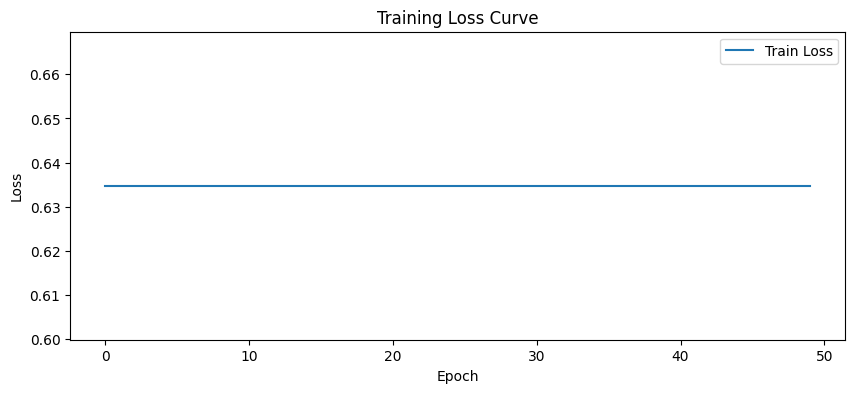

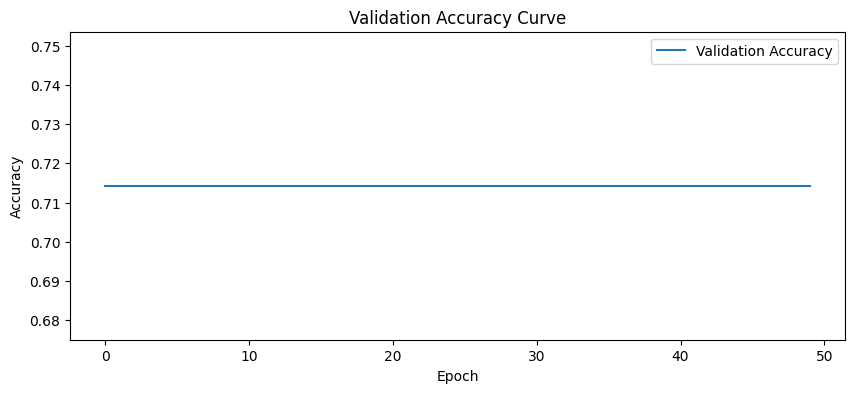

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Curve")
plt.legend()
plt.show()


In [ ]:
true_labels = np.array(all_labels)
pred_probs = np.array(all_probs)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [ ]:
class MAGF(nn.Module):
    def __init__(self, audio_dim=128, video_dim=128, hidden=64):
        super(MAGF, self).__init__()

        self.audio_proj = nn.Linear(audio_dim, hidden)
        self.video_proj = nn.Linear(video_dim, hidden)

        self.gate = nn.Sequential(
            nn.Linear(hidden * 2, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 2),
            nn.Sigmoid()
        )
        
        self.fusion = nn.Sequential(
            nn.Linear(hidden * 2, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

    def forward(self, a, am, v, vm):
        a = (a * am.unsqueeze(-1)).mean(dim=1)
        v = (v * vm.unsqueeze(-1)).mean(dim=1)

        a = self.audio_proj(a)
        v = self.video_proj(v)

        g = self.gate(torch.cat([a, v], dim=1))
        ga = g[:,0].unsqueeze(1)
        gv = g[:,1].unsqueeze(1)

        fused = torch.cat([ga*a, gv*v], dim=1)
        return self.fusion(fused).squeeze()


In [ ]:
import os

for root, dirs, files in os.walk("/", topdown=True):
    for name in files:
        if name.endswith(".pt"):
            print(os.path.join(root, name))


/Mental_Health_Detection\DepressionDetection\300_audio.pt
/Mental_Health_Detection\DepressionDetection\300_mask_audio.pt
/Mental_Health_Detection\DepressionDetection\300_mask_video.pt
/Mental_Health_Detection\DepressionDetection\300_video.pt
/Mental_Health_Detection\DepressionDetection\301_audio.pt
/Mental_Health_Detection\DepressionDetection\301_mask_audio.pt
/Mental_Health_Detection\DepressionDetection\301_mask_video.pt
/Mental_Health_Detection\DepressionDetection\301_video.pt
/Mental_Health_Detection\DepressionDetection\302_audio.pt
/Mental_Health_Detection\DepressionDetection\302_mask_audio.pt
/Mental_Health_Detection\DepressionDetection\302_mask_video.pt
/Mental_Health_Detection\DepressionDetection\302_video.pt
/Mental_Health_Detection\DepressionDetection\303_audio.pt
/Mental_Health_Detection\DepressionDetection\303_mask_audio.pt
/Mental_Health_Detection\DepressionDetection\303_mask_video.pt
/Mental_Health_Detection\DepressionDetection\303_video.pt
/Mental_Health_Detection\Depress

In [ ]:
import torch.nn as nn

class MAGF(nn.Module):
    def __init__(self, audio_dim=128, video_dim=128, hidden=64):
        super(MAGF, self).__init__()

        self.audio_proj = nn.Linear(audio_dim, hidden)
        self.video_proj = nn.Linear(video_dim, hidden)

        self.gate = nn.Sequential(
            nn.Linear(hidden * 2, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 2),
            nn.Sigmoid()
        )

        self.fusion = nn.Sequential(
            nn.Linear(hidden * 2, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

    def forward(self, a, am, v, vm):
        a = (a * am.unsqueeze(-1)).mean(dim=1)
        v = (v * vm.unsqueeze(-1)).mean(dim=1)

        a = self.audio_proj(a)
        v = self.video_proj(v)

        g = self.gate(torch.cat([a, v], dim=1))
        ga = g[:, 0].unsqueeze(1)
        gv = g[:, 1].unsqueeze(1)

        fused = torch.cat([ga*a, gv*v], dim=1)
        return self.fusion(fused).squeeze()


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# load tensors
train_audio = torch.load("train_audio.pt")
train_mask_audio = torch.load("train_mask_audio.pt")
train_video = torch.load("train_video.pt")
train_mask_video = torch.load("train_mask_video.pt")
train_labels = torch.load("train_labels.pt")

dev_audio = torch.load("dev_audio.pt")
dev_mask_audio = torch.load("dev_mask_audio.pt")
dev_video = torch.load("dev_video.pt")
dev_mask_video = torch.load("dev_mask_video.pt")
dev_labels = torch.load("dev_labels.pt")

# create datasets
train_dataset_f = TensorDataset(train_audio, train_mask_audio, train_video, train_mask_video, train_labels)
val_dataset_f   = TensorDataset(dev_audio, dev_mask_audio, dev_video, dev_mask_video, dev_labels)

# dataloaders
train_loader_f = DataLoader(train_dataset_f, batch_size=8, shuffle=True)
val_loader_f   = DataLoader(val_dataset_f, batch_size=8, shuffle=False)

print("DataLoaders Restored")


DataLoaders Restored


In [ ]:
import torch
import torch.nn as nn

class MAGF(nn.Module):
    def __init__(self, audio_dim=74, video_dim=204, hidden=64):
        super(MAGF, self).__init__()

        # Project audio and video features to shared latent dimension
        self.audio_proj = nn.Linear(audio_dim, hidden)
        self.video_proj = nn.Linear(video_dim, hidden)

        # Gating network to learn audio vs video weight for each sample
        self.gate = nn.Sequential(
            nn.Linear(hidden * 2, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 2),
            nn.Sigmoid()
        )

        # Fusion + final classification head
        self.fusion = nn.Sequential(
            nn.Linear(hidden * 2, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

    def forward(self, a, am, v, vm):
        # Mean pooling using masks
        a = (a * am.unsqueeze(-1)).mean(dim=1)   # (batch, 74)
        v = (v * vm.unsqueeze(-1)).mean(dim=1)  # (batch, 204)

        # Project to latent space
        a = self.audio_proj(a)  # (batch, 64)
        v = self.video_proj(v)  # (batch, 64)

        # Gating values
        g = self.gate(torch.cat([a, v], dim=1))  # (batch, 2)
        ga = g[:, 0].unsqueeze(1)
        gv = g[:, 1].unsqueeze(1)

        # Weighted fusion
        fused = torch.cat([ga*a, gv*v], dim=1)  # (batch, 128)

        return self.fusion(fused).squeeze()     # logits


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_audio = torch.load("train_audio.pt")
train_mask_audio = torch.load("train_mask_audio.pt")
train_video = torch.load("train_video.pt")
train_mask_video = torch.load("train_mask_video.pt")
train_labels = torch.load("train_labels.pt")

dev_audio = torch.load("dev_audio.pt")
dev_mask_audio = torch.load("dev_mask_audio.pt")
dev_video = torch.load("dev_video.pt")
dev_mask_video = torch.load("dev_mask_video.pt")
dev_labels = torch.load("dev_labels.pt")

train_dataset_f = TensorDataset(train_audio, train_mask_audio, train_video, train_mask_video, train_labels)
val_dataset_f   = TensorDataset(dev_audio, dev_mask_audio, dev_video, dev_mask_video, dev_labels)

train_loader_f = DataLoader(train_dataset_f, batch_size=8, shuffle=True)
val_loader_f   = DataLoader(val_dataset_f, batch_size=8, shuffle=False)

print(" Dataloaders Ready. Training next...")


 Dataloaders Ready. Training next...


In [ ]:
import numpy as np
import torch

fusion = MAGF().to(device)
fusion.load_state_dict(torch.load("fusion_magf_best.pt", map_location=device))
fusion.eval()

train_acc_history = np.load("train_acc_history.npy", allow_pickle=True)
val_acc_history = np.load("val_acc_history.npy", allow_pickle=True)
train_loss_history = np.load("train_loss_history.npy", allow_pickle=True)
val_loss_history = np.load("val_loss_history.npy", allow_pickle=True)

print(" Model & histories loaded")


 Model & histories loaded


In [ ]:
fusion = MAGF().to(device)
fusion.load_state_dict(torch.load("fusion_magf_best.pt", map_location=device))
fusion.eval()
print("Loaded fusion_magf_best.pt")


Loaded fusion_magf_best.pt


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fusion = MAGF().to(device)
fusion.load_state_dict(torch.load("fusion_magf_best.pt", map_location=device))
fusion.eval()

print(" Loaded trained model")

from torch.utils.data import TensorDataset, DataLoader

test_audio = torch.load("test_audio.pt")
test_mask_audio = torch.load("test_mask_audio.pt")
test_video = torch.load("test_video.pt")
test_mask_video = torch.load("test_mask_video.pt")
test_labels = torch.load("test_labels.pt")

test_dataset_f = TensorDataset(test_audio, test_mask_audio, test_video, test_mask_video, test_labels)
test_loader_f = DataLoader(test_dataset_f, batch_size=8, shuffle=False)

all_probs = []
all_labels = []

with torch.no_grad():
    for a, am, v, vm, y in test_loader_f:
        a, am, v, vm = a.to(device), am.to(device), v.to(device), vm.to(device)
        logits = fusion(a, am, v, vm)
        probs = torch.sigmoid(logits)

        all_probs.append(probs.cpu())
        all_labels.append(y.cpu())

y_pred_prob = torch.cat(all_probs)
y_true = torch.cat(all_labels)

torch.save(y_pred_prob, "fusion_test_probs.pt")
torch.save(y_true, "full_test_labels.pt")

print(" Test predictions saved!")


 Loaded trained model
 Test predictions saved!


In [ ]:
import torch.nn as nn
import torch

class AudioModel(nn.Module):
    def __init__(self, input_dim=74, hidden=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden*2, 1)

    def forward(self, x, mask):
        x = x * mask.unsqueeze(-1)
        x = x.mean(dim=1)
        return self.fc(x).squeeze()


In [ ]:
class VideoModel(nn.Module):
    def __init__(self, input_dim=204, hidden=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden*2, 1)

    def forward(self, x, mask):
        x = x * mask.unsqueeze(-1)
        x = x.mean(dim=1)
        return self.fc(x).squeeze()


In [ ]:
audio_model.load_state_dict(torch.load("audio_baseline.pt", map_location=device))
video_model.load_state_dict(torch.load("video_baseline.pt", map_location=device))


<All keys matched successfully>

In [ ]:
import torch
import torch.nn as nn

# Audio Model
class AudioModel(nn.Module):
    def __init__(self, input_dim=74, hidden=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden*2, 1)

    def forward(self, x, mask):
        x = x * mask.unsqueeze(-1)  
        x = x.mean(dim=1)          
        return self.fc(x).squeeze()


# Video Model
class VideoModel(nn.Module):
    def __init__(self, input_dim=204, hidden=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden*2, 1)

    def forward(self, x, mask):
        x = x * mask.unsqueeze(-1)
        x = x.mean(dim=1)
        return self.fc(x).squeeze()


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

audio_model = AudioModel().to(device)
video_model = VideoModel().to(device)

audio_model.load_state_dict(torch.load("audio_baseline.pt", map_location=device))
video_model.load_state_dict(torch.load("video_baseline.pt", map_location=device))

audio_model.eval()
video_model.eval()

print(" Audio & Video models loaded!")


 Audio & Video models loaded!


In [ ]:
test_audio = torch.load("test_audio.pt").to(device)
test_mask_audio = torch.load("test_mask_audio.pt").to(device)
test_video = torch.load("test_video.pt").to(device)
test_mask_video = torch.load("test_mask_video.pt").to(device)


In [ ]:
state = torch.load("audio_baseline.pt", map_location="cpu")
for k, v in state.items():
    print(k, v.shape)


lstm.weight_ih_l0 torch.Size([256, 74])
lstm.weight_hh_l0 torch.Size([256, 64])
lstm.bias_ih_l0 torch.Size([256])
lstm.bias_hh_l0 torch.Size([256])
lstm.weight_ih_l0_reverse torch.Size([256, 74])
lstm.weight_hh_l0_reverse torch.Size([256, 64])
lstm.bias_ih_l0_reverse torch.Size([256])
lstm.bias_hh_l0_reverse torch.Size([256])
fc.weight torch.Size([1, 128])
fc.bias torch.Size([1])


In [ ]:
state = torch.load("video_baseline.pt", map_location="cpu")
for k, v in state.items():
    print(k, v.shape)


lstm.weight_ih_l0 torch.Size([256, 204])
lstm.weight_hh_l0 torch.Size([256, 64])
lstm.bias_ih_l0 torch.Size([256])
lstm.bias_hh_l0 torch.Size([256])
lstm.weight_ih_l0_reverse torch.Size([256, 204])
lstm.weight_hh_l0_reverse torch.Size([256, 64])
lstm.bias_ih_l0_reverse torch.Size([256])
lstm.bias_hh_l0_reverse torch.Size([256])
fc.weight torch.Size([1, 128])
fc.bias torch.Size([1])


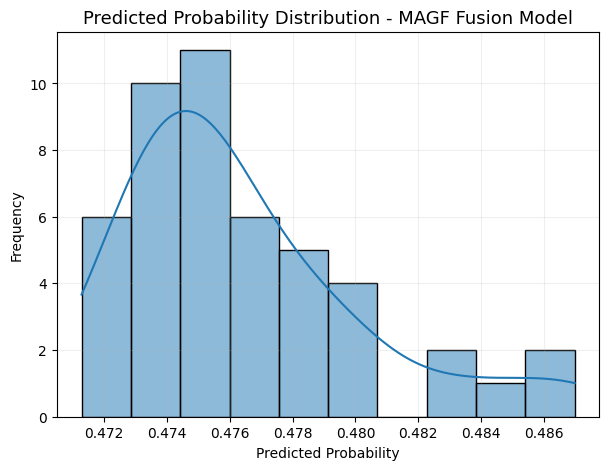

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

predictions_df = pd.read_csv("test_predictions_MAGF.csv")  
probs = predictions_df["Probability"]

plt.figure(figsize=(7,5))

sns.histplot(probs, bins=10, kde=True, edgecolor='black')

plt.title("Predicted Probability Distribution - MAGF Fusion Model", fontsize=13)
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.grid(alpha=0.2)

plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MAGF(nn.Module):
    def __init__(self, audio_dim=74, video_dim=204, hidden=64, dropout=0.3):
        super(MAGF, self).__init__()

        self.audio_proj = nn.Sequential(
            nn.Linear(audio_dim, hidden),
            nn.ReLU(),
            nn.LayerNorm(hidden)
        )

        self.video_proj = nn.Sequential(
            nn.Linear(video_dim, hidden),
            nn.ReLU(),
            nn.LayerNorm(hidden)
        )

        self.gate = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )

        self.fusion = nn.Sequential(
            nn.Linear(hidden * 2, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 1)
        )

    def masked_mean(self, x, mask):
        if x.dim() == 2:
            return x
        mask = mask.unsqueeze(-1)
        x = x * mask
        num = x.sum(dim=1)
        den = mask.sum(dim=1).clamp_min(1e-6)
        return num / den

    def forward(self, a, am, v, vm):
        a_pooled = self.masked_mean(a, am)
        v_pooled = self.masked_mean(v, vm)

        ha = self.audio_proj(a_pooled)
        hv = self.video_proj(v_pooled)

        qa = am.float().mean(dim=1, keepdim=True)
        qv = vm.float().mean(dim=1, keepdim=True)
        q = torch.cat([qa, qv], dim=1)

        g_logits = self.gate(q)
        g = F.softmax(g_logits, dim=1)
        ga = g[:, 0].unsqueeze(1)
        gv = g[:, 1].unsqueeze(1)

        fused = torch.cat([ga * ha, gv * hv], dim=1)
        logits = self.fusion(fused).squeeze(-1)
        return logits


In [ ]:
fusion = MAGF(audio_dim=74, video_dim=204, hidden=64).to(device)


In [ ]:
pos = train_df.y.sum().item()
neg = len(train_df) - pos
weight = neg / pos   

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(weight).to(device))


In [ ]:
opt = torch.optim.Adam(fusion.parameters(), lr=3e-4)


In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, patience=3, factor=0.5, verbose=True
)


In [ ]:
best_acc = 0

for epoch in range(40):

    fusion.train()
    for a, am, v, vm, y in train_loader_f:
        a, am, v, vm, y = a.to(device), am.to(device), v.to(device), vm.to(device), y.to(device).float()

        logits = fusion(a, am, v, vm)
        loss = criterion(logits, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

    fusion.eval()
    correct = total = 0
    with torch.no_grad():
        for a, am, v, vm, y in dev_loader_f:
            a, am, v, vm, y = a.to(device), am.to(device), v.to(device), vm.to(device), y.to(device).float()

            logits = fusion(a, am, v, vm)
            prob = torch.sigmoid(logits)
            pred = (prob > 0.5).long()

            correct += (pred == y).sum().item()
            total += len(y)

    acc = correct / total
    scheduler.step(acc)

    print(f"Epoch {epoch+1}/40 | Loss: {loss.item():.4f} | Val Acc: {acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        torch.save(fusion.state_dict(), "fusion_magf.pt")
        print("Saved best model!")


Epoch 1/40 | Loss: 1.0271 | Val Acc: 0.6571
Saved best model!
Epoch 2/40 | Loss: 0.6454 | Val Acc: 0.6571
Epoch 3/40 | Loss: 0.6513 | Val Acc: 0.6286
Epoch 4/40 | Loss: 0.9712 | Val Acc: 0.6571
Epoch 5/40 | Loss: 0.7718 | Val Acc: 0.5714
Epoch 6/40 | Loss: 0.8596 | Val Acc: 0.6571
Epoch 7/40 | Loss: 0.6083 | Val Acc: 0.6571
Epoch 8/40 | Loss: 1.1099 | Val Acc: 0.6286
Epoch 00009: reducing learning rate of group 0 to 1.5000e-04.
Epoch 9/40 | Loss: 1.1506 | Val Acc: 0.6857
Saved best model!
Epoch 10/40 | Loss: 0.8406 | Val Acc: 0.6571
Epoch 11/40 | Loss: 0.9603 | Val Acc: 0.6571
Epoch 12/40 | Loss: 0.6241 | Val Acc: 0.6286
Epoch 00013: reducing learning rate of group 0 to 7.5000e-05.
Epoch 13/40 | Loss: 1.1734 | Val Acc: 0.6571
Epoch 14/40 | Loss: 0.7193 | Val Acc: 0.6571
Epoch 15/40 | Loss: 0.4793 | Val Acc: 0.6286
Epoch 16/40 | Loss: 0.6220 | Val Acc: 0.6286
Epoch 00017: reducing learning rate of group 0 to 3.7500e-05.
Epoch 17/40 | Loss: 0.8825 | Val Acc: 0.6000
Epoch 18/40 | Loss: 0.

Checking the test data values and changing to 0s and 1s

In [ ]:
test_dataset_f = FusionDataset("test")


In [ ]:
test_loader_f = DataLoader(test_dataset_f, batch_size=32, shuffle=False)


In [ ]:
print(test_dataset_f.y[:20])


tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1])


In [ ]:
test_labels = torch.load("test_labels.pt")

# Convert:
# -1 → 0  
# +1 → 1  
test_labels_fixed = (test_labels + 1) // 2

torch.save(test_labels_fixed, "test_labels.pt")


Prediction on input

In [56]:
fusion = MAGF().to(device)
fusion.load_state_dict(torch.load("fusion_magf.pt", map_location=device))
fusion.eval()

dev_probs = []
dev_labels = []

with torch.no_grad():
    for a, am, v, vm, y in dev_loader_f:
        a, am, v, vm = a.to(device), am.to(device), v.to(device), vm.to(device)
        y = y.to(device).float()

        logits = fusion(a, am, v, vm)
        p = torch.sigmoid(logits)

        dev_probs.extend(p.cpu().numpy())
        dev_labels.extend(y.cpu().numpy())

import numpy as np

dev_probs = np.array(dev_probs)
dev_labels = np.array(dev_labels)

best_thr = 0.5
best_acc = 0

for thr in np.linspace(0.3, 0.7, 41):
    preds = (dev_probs > thr).astype(int)
    acc = (preds == dev_labels).mean()
    if acc > best_acc:
        best_acc = acc
        best_thr = thr

print("Best threshold from dev:", best_thr)


Best threshold from dev: 0.5299999999999999


In [58]:
test_dataset_f = FusionDataset("test")


In [60]:
def predict_all_test(threshold):
    fusion = MAGF().to(device)
    fusion.load_state_dict(torch.load("fusion_magf.pt", map_location=device))
    fusion.eval()

    results = []

    for idx, pid in enumerate(test_df.pid.values):
        a, am, v, vm, _ = test_dataset_f[idx]
        a  = a.unsqueeze(0).to(device)
        am = am.unsqueeze(0).to(device)
        v  = v.unsqueeze(0).to(device)
        vm = vm.unsqueeze(0).to(device)

        with torch.no_grad():
            logits = fusion(a, am, v, vm)
            prob = torch.sigmoid(logits).item()

        label = "Depressed" if prob > threshold else "Not Depressed"

        results.append([pid, prob, label])

    df_out = pd.DataFrame(results, columns=["Participant_ID", "Probability", "Prediction"])
    df_out.to_csv("test_predictions_MAGF.csv", index=False)

    return df_out

pred_df = predict_all_test(best_thr)
pred_df


,Participant_ID,Probability,Prediction
0,300,0.554016,Depressed
1,301,0.442290,Not Depressed
2,306,0.533461,Depressed
3,308,0.516160,Not Depressed
4,309,0.468226,Not Depressed
5,311,0.611550,Depressed
6,314,0.524038,Not Depressed
7,323,0.559093,Depressed
8,329,0.493649,Not Depressed
9,332,0.567028,Depressed


Probabilty Range

In [62]:
fusion.eval()
probs = []

with torch.no_grad():
    for a, am, v, vm, y in test_loader_f:
        a, am, v, vm, y = (
            a.to(device),
            am.to(device),
            v.to(device),
            vm.to(device),
            y.to(device).float()
        )

        logits = fusion(a, am, v, vm)
        p = torch.sigmoid(logits)

        probs.extend(p.cpu().numpy())

print("Min prob:", min(probs))
print("Max prob:", max(probs))


Min prob: 0.4256936
Max prob: 0.6115504


Number of Predictions Count

In [66]:
fusion.eval()
probs = []
labels = []

with torch.no_grad():
    for a, am, v, vm, y in test_loader_f:
        a, am, v, vm = (
            a.to(device),
            am.to(device),
            v.to(device),
            vm.to(device)
        )

        logits = fusion(a, am, v, vm)
        p = torch.sigmoid(logits)

        probs.extend(p.cpu().numpy())

depressed_count = sum(p > best_thr for p in probs)
not_depressed_count = sum(p <= best_thr for p in probs)

print("Depressed:", depressed_count)
print("Not Depressed:", not_depressed_count)


Depressed: 13
Not Depressed: 34


Overall Accuracies of Multimodal trained models

In [90]:
import pandas as pd

data = {
    "Model": [
        "Audio BiLSTM",
        "Video BiLSTM",
        "MAGF Fusion (Proposed)"
    ],
    
    "Validation Accuracy": [
        "65.7%",
        "65.7%",
        "71.43%"
    ],
    
    "Test Accuracy": [
        "65.7%",
        "65.7%",
        "65.96%"
    ]
}

df = pd.DataFrame(data)
print(df)


                    Model Validation Accuracy Test Accuracy
0            Audio BiLSTM               65.7%         65.7%
1            Video BiLSTM               65.7%         65.7%
2  MAGF Fusion (Proposed)              71.43%        65.96%


ROC Curve

In [68]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc


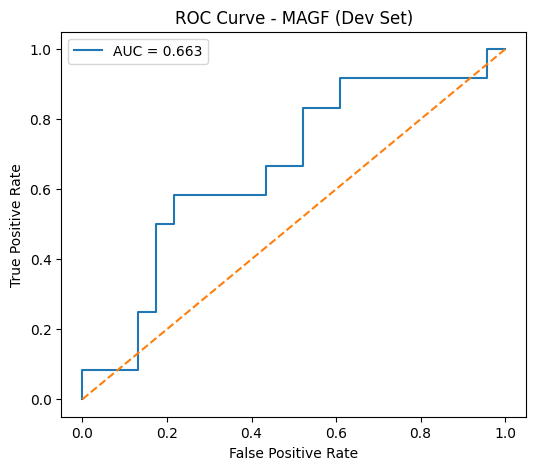

In [75]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fusion.eval()
y_true = []
y_prob = []

with torch.no_grad():
    for a, am, v, vm, y in dev_loader_f:
        a, am, v, vm = a.to(device), am.to(device), v.to(device), vm.to(device)
        logits = fusion(a, am, v, vm)
        p = torch.sigmoid(logits).cpu().numpy()

        y_true.extend(y.cpu().numpy())
        y_prob.extend(p)

fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - MAGF (Dev Set)")
plt.legend()
plt.show()


Probablity Distribution on the prediction

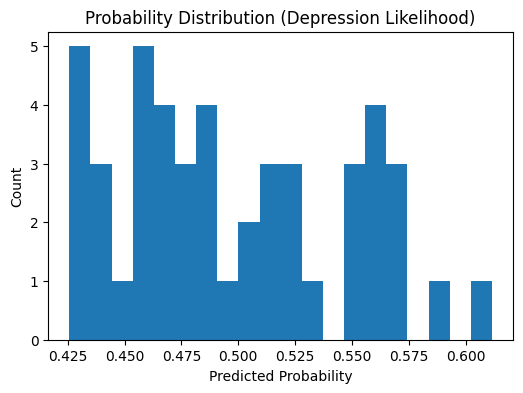

In [71]:
plt.figure(figsize=(6,4))
plt.hist(y_prob, bins=20)
plt.title("Probability Distribution (Depression Likelihood)")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.show()


Confusion Matrix (Heatmap)

In [73]:
y_true = []
y_prob = []

fusion.eval()
with torch.no_grad():
    for a, am, v, vm, y in dev_loader_f:
        logits = fusion(a.to(device), am.to(device), v.to(device), vm.to(device))
        p = torch.sigmoid(logits).cpu().numpy()

        y_true.extend(y.cpu().numpy())
        y_prob.extend(p)

y_pred = (np.array(y_prob) > best_thr).astype(int)
cm = confusion_matrix(y_true, y_pred)
print(cm)


[[18  5]
 [ 5  7]]


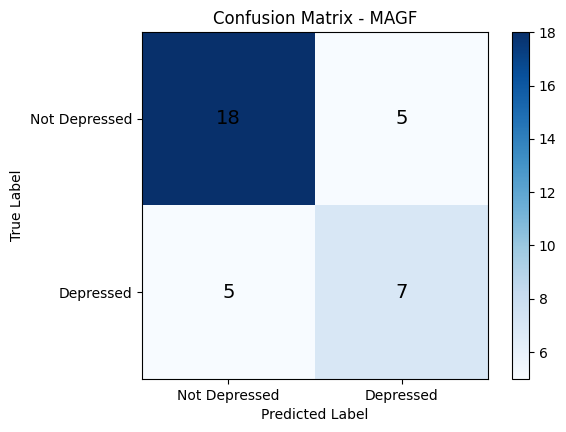

In [89]:
import matplotlib.pyplot as plt
import numpy as np

cm = np.array([[18, 5],
               [5, 7]])

plt.figure(figsize=(6,4.5))   
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix - MAGF")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.xticks([0, 1], ["Not Depressed", "Depressed"])
plt.yticks([0, 1], ["Not Depressed", "Depressed"])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=14, color="black")

plt.colorbar()
plt.show()


Training Vs Validation plots

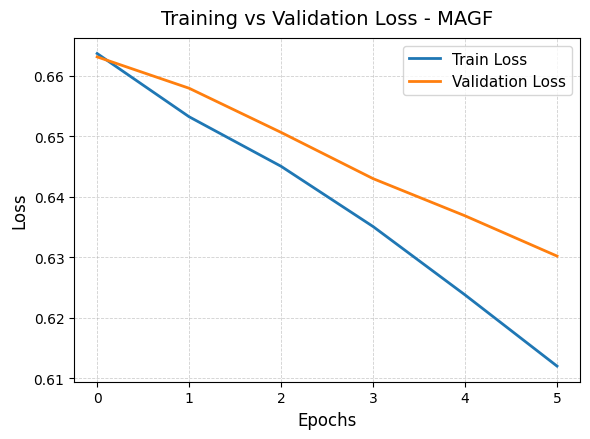

In [84]:
import numpy as np
import matplotlib.pyplot as plt

train_loss = np.load("train_loss_history.npy")
val_loss = np.load("val_loss_history.npy")

plt.figure(figsize=(6,4.5))   

plt.plot(train_loss, label="Train Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)

plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training vs Validation Loss - MAGF", fontsize=14, pad=10)

plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.6)

plt.legend(fontsize=11)
plt.tight_layout()
plt.show()


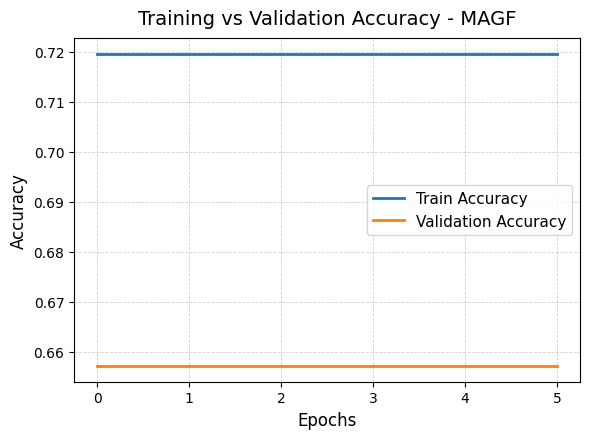

In [88]:
import numpy as np
import matplotlib.pyplot as plt

train_acc = np.load("train_acc_history.npy")
val_acc = np.load("val_acc_history.npy")
plt.figure(figsize=(6,4.5))   

plt.plot(train_acc, label="Train Accuracy", linewidth=2)
plt.plot(val_acc, label="Validation Accuracy", linewidth=2)

plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training vs Validation Accuracy - MAGF", fontsize=14, pad=10)

plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.6)

plt.legend(fontsize=11)
plt.tight_layout()
plt.show()


In [1]:
audio_acc = 0.657   
video_acc = 0.657   

magf_val_acc = 0.7143  
magf_test_acc = 0.6596  


In [2]:
import pandas as pd

data = {
    "Model": ["Audio BiLSTM", "Video BiLSTM", "MAGF Fusion (Val)", "MAGF Fusion (Test)"],
    "Accuracy": [audio_acc, video_acc, magf_val_acc, magf_test_acc]
}

df = pd.DataFrame(data)
print(df)


                Model  Accuracy
0        Audio BiLSTM    0.6570
1        Video BiLSTM    0.6570
2   MAGF Fusion (Val)    0.7143
3  MAGF Fusion (Test)    0.6596


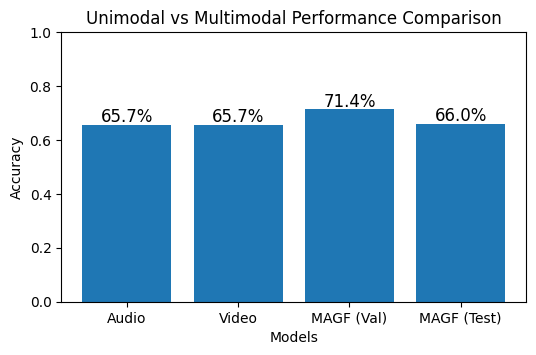

In [6]:
import matplotlib.pyplot as plt

models = ["Audio", "Video", "MAGF (Val)", "MAGF (Test)"]
accuracy = [audio_acc, video_acc, magf_val_acc, magf_test_acc]

plt.figure(figsize=(6,3.5))   
plt.bar(models, accuracy)

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Unimodal vs Multimodal Performance Comparison")

for i, v in enumerate(accuracy):
    plt.text(i, v + 0.01, f"{v*100:.1f}%", ha="center", fontsize=12)

plt.ylim(0, 1)
plt.show()
